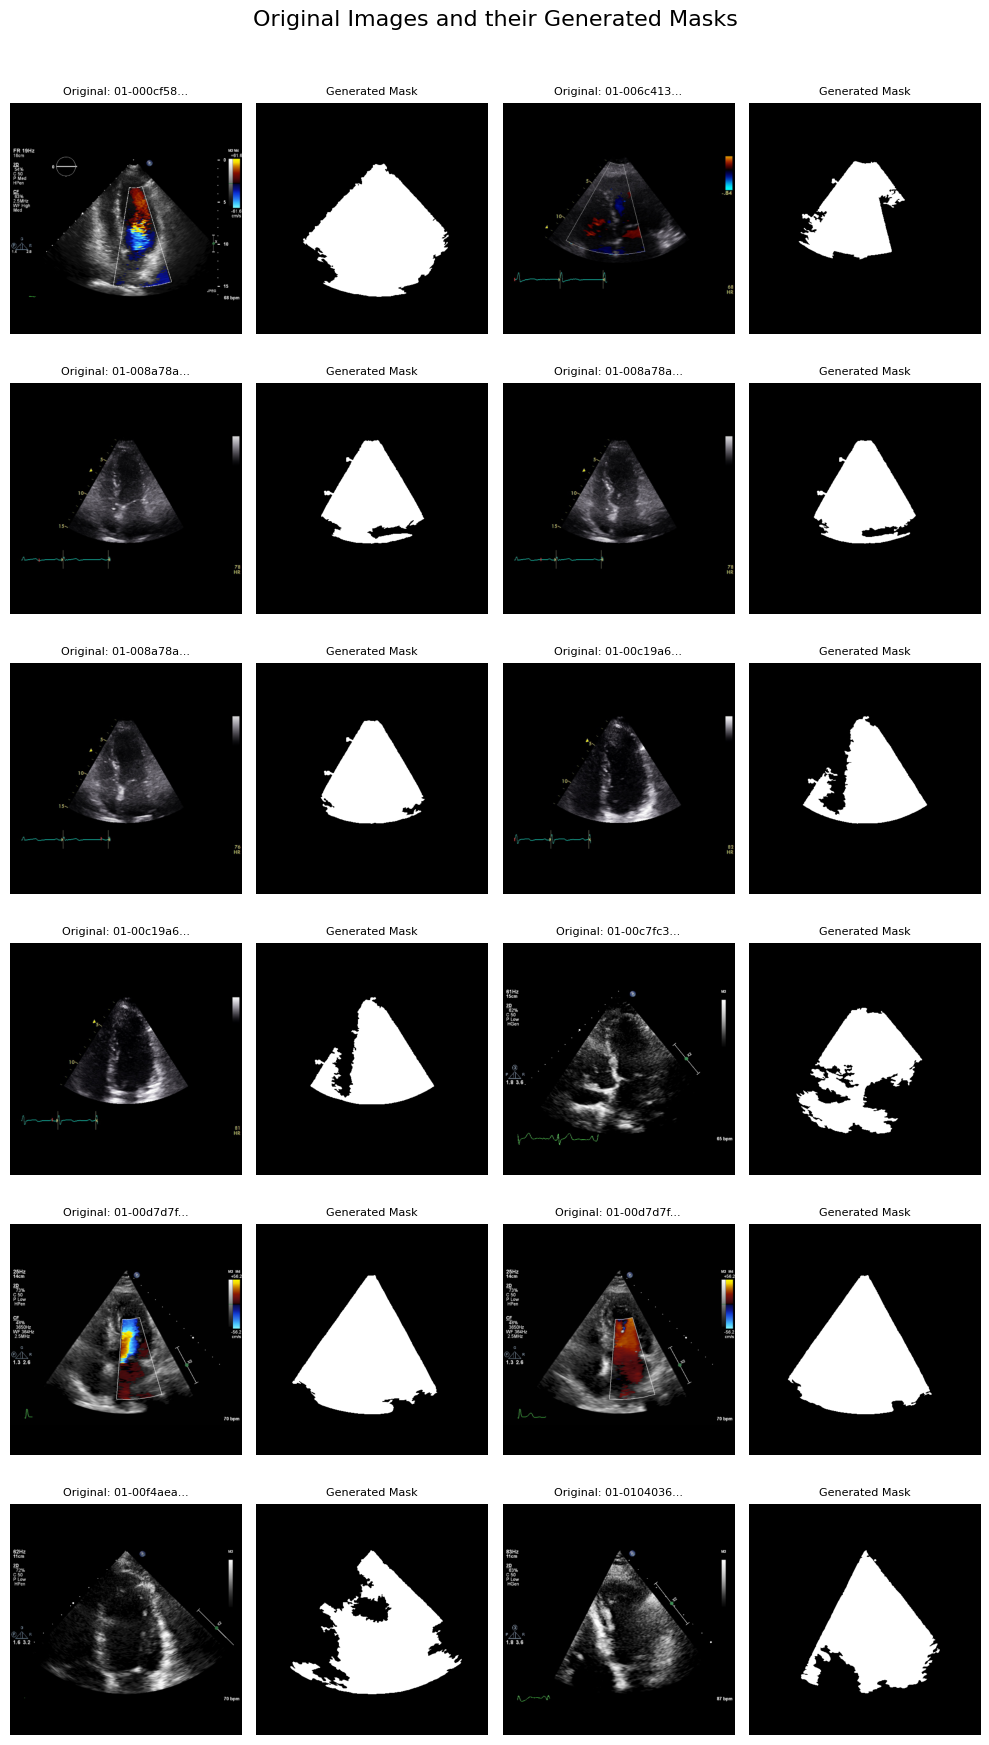

In [18]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def create_ultrasound_mask(image, threshold_value=15):
    """
    Detects the fan-shaped region in a loaded ultrasound image and returns a binary mask.

    Args:
        image (numpy.ndarray): The input image loaded by OpenCV.
        threshold_value (int): The brightness cutoff to separate the fan from the background.
                               You may need to adjust this value (between 5 and 30 is common).

    Returns:
        numpy.ndarray: A binary mask of the detected fan shape.
    """
    # Convert to grayscale and apply a blur to reduce noise
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Create a binary image using a simple threshold
    _, thresh = cv2.threshold(blurred, threshold_value, 255, cv2.THRESH_BINARY)

    # Find all the outlines (contours) in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contours were found, return an empty (black) mask
    if not contours:
        return np.zeros(image.shape[:2], dtype="uint8")

    # Assume the fan is the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Create a new black image and draw the largest contour on it in white
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    return mask

# --- Main part of the script ---

# IMPORTANT: Replace this placeholder with the correct path to your image folder.
# For example: "C:/Users/YourUser/Desktop/ultrasound_images"
images_path = "/workspace/data/unity-u4s/images/training" 

# Check if the path exists
if not os.path.isdir(images_path):
    print(f"Error: The directory was not found.")
    print(f"Please update the 'images_path' variable in the script with the correct location.")
else:
    # Get a sorted list of image files from your directory
    image_files = sorted([f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Select the first 12 images to display
    images_to_plot = image_files[:12]

    if not images_to_plot:
        print(f"No image files found in '{images_path}'.")
    else:
        # Create a plot to display images and masks side-by-side
        # The layout is 6 rows by 4 columns to fit 12 pairs of images
        fig, axes = plt.subplots(6, 4, figsize=(10, 18))
        fig.suptitle("Original Images and their Generated Masks", fontsize=16)

        # Flatten the axes array for easy iteration
        axes = axes.ravel()

        for i, image_name in enumerate(images_to_plot):
            full_path = os.path.join(images_path, image_name)
            
            # Read the original image
            original_image = cv2.imread(full_path)
            
            # Proceed if the image was loaded correctly
            if original_image is not None:
                original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
                
                # Create the mask
                mask = create_ultrasound_mask(original_image)

                # Plot Original Image in the left column
                axes[i*2].imshow(original_image_rgb)
                axes[i*2].set_title(f"Original: {image_name[:10]}...", fontsize=8)
                axes[i*2].axis('off')

                # Plot Mask in the right column
                axes[i*2+1].imshow(mask, cmap='gray')
                axes[i*2+1].set_title("Generated Mask", fontsize=8)
                axes[i*2+1].axis('off')

        # Hide any unused subplots if you have less than 12 images
        for j in range(len(images_to_plot) * 2, len(axes)):
            axes[j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

Processing 50 images from: /workspace/data/unity-u4s/images/training
[01/50] Saved → /workspace/data/unity-u4s/images/training/_fanmask_out/01-000cf58f1811cb7c93003429b2350f92a40e0fc65bd71775b0abb833666fa060-0002_boosted.png, /workspace/data/unity-u4s/images/training/_fanmask_out/01-000cf58f1811cb7c93003429b2350f92a40e0fc65bd71775b0abb833666fa060-0002_mask.png, /workspace/data/unity-u4s/images/training/_fanmask_out/01-000cf58f1811cb7c93003429b2350f92a40e0fc65bd71775b0abb833666fa060-0002_overlay.png
[02/50] Saved → /workspace/data/unity-u4s/images/training/_fanmask_out/01-006c413d2042cb781f056204a5c50d70ef73dae64efeab2c11e2a6d3258b8487-0000_boosted.png, /workspace/data/unity-u4s/images/training/_fanmask_out/01-006c413d2042cb781f056204a5c50d70ef73dae64efeab2c11e2a6d3258b8487-0000_mask.png, /workspace/data/unity-u4s/images/training/_fanmask_out/01-006c413d2042cb781f056204a5c50d70ef73dae64efeab2c11e2a6d3258b8487-0000_overlay.png
[03/50] Saved → /workspace/data/unity-u4s/images/training/_fa

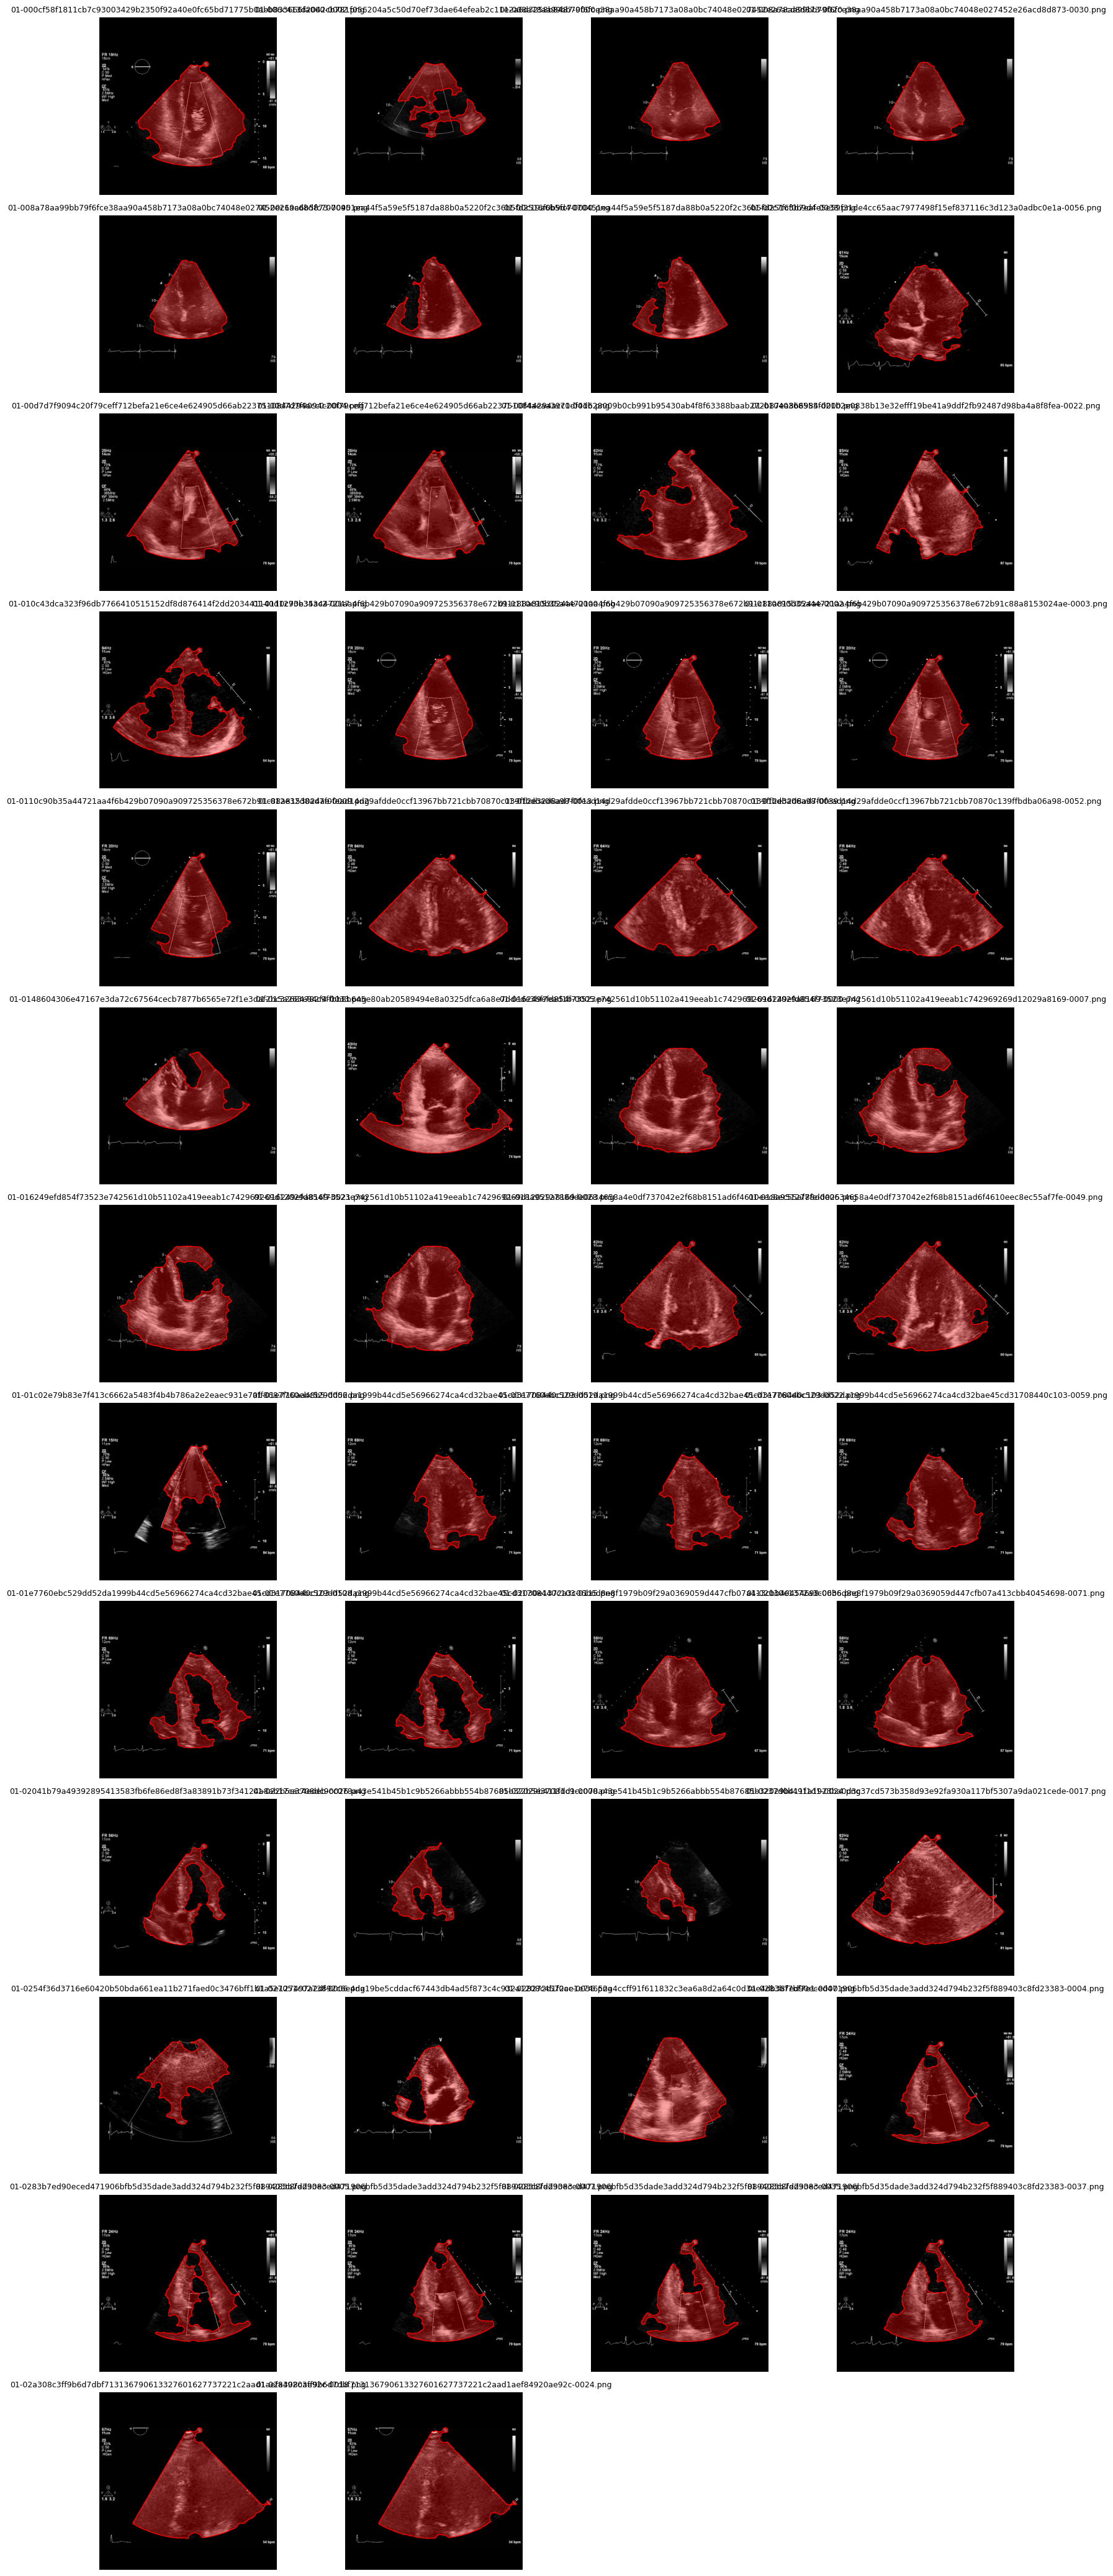

Done. Outputs in: /workspace/data/unity-u4s/images/training/_fanmask_out


In [14]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T  # <- per your request

# -----------------------------
# Small helpers
# -----------------------------
def ensure_gray(img_any):
    """Return a single-channel uint8 grayscale image from gray/BGR/BGRA input."""
    if img_any is None:
        raise ValueError("Input image is None.")
    if img_any.ndim == 2:
        gray = img_any
    elif img_any.ndim == 3 and img_any.shape[2] == 3:
        gray = cv2.cvtColor(img_any, cv2.COLOR_BGR2GRAY)
    elif img_any.ndim == 3 and img_any.shape[2] == 4:
        gray = cv2.cvtColor(img_any, cv2.COLOR_BGRA2GRAY)
    else:
        raise ValueError("Unsupported image shape: {}".format(img_any.shape))
    if gray.dtype != np.uint8:
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return gray

def to_rgb_for_display(img_any):
    """Return an RGB image for matplotlib, from gray/BGR/BGRA input."""
    if img_any.ndim == 2:
        return cv2.cvtColor(img_any, cv2.COLOR_GRAY2RGB)
    raise ValueError("Unsupported image shape: {}".format(img_any.shape))

# -----------------------------
# Brightness boost (ColorJitter)
# -----------------------------
def boost_brightness_colorjitter_gray(img_gray):
    g = ensure_gray(img_gray)

    # Apply ColorJitter (same logic/style you shared)
    pil_img = Image.fromarray(g, mode="L")
    jitter = T.ColorJitter(brightness=0, contrast=1, saturation=0, hue=0)
    boosted = jitter(pil_img)  # PIL Image out (random factor each call)
    jitter = T.ColorJitter(brightness=1, contrast=0, saturation=0, hue=0)
    boosted = jitter(boosted)  # PIL Image out (random factor each call)
    jitter = T.ColorJitter(brightness=0, contrast=1, saturation=0, hue=0)
    boosted = jitter(boosted)  # PIL Image out (random factor each call)
    out = np.array(boosted, dtype=np.uint8)
    return img_gray

# -----------------------------
# Fan mask via morphology (unchanged)
# -----------------------------
def fan_mask_morphology(img_any, thr=15, open_ks=5, close_ks=21):
    """
    Returns a binary fan/scan mask (uint8, {0,255}) for an ultrasound image.
    - thr:      binary threshold (background is near-black in most US images)
    - open_ks:  kernel size for opening (remove small bright specks)
    - close_ks: kernel size for closing (fill gaps and round the arc)
    """
    gray = ensure_gray(img_any)

    # Threshold (unchanged logic)
    _, bin0 = cv2.threshold(gray, int(thr), 255, cv2.THRESH_BINARY)

    # Morphology: open (denoise) then close (fill/smooth)
    k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
    bin1    = cv2.morphologyEx(bin0, cv2.MORPH_OPEN,  k_open,  iterations=1)
    bin2    = cv2.morphologyEx(bin1, cv2.MORPH_CLOSE, k_close, iterations=1)

    # Keep largest connected component (the scan sector)
    contours, _ = cv2.findContours(bin2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros_like(bin2, dtype=np.uint8)
    largest = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(bin2, dtype=np.uint8)
    cv2.drawContours(mask, [largest], -1, 255, thickness=cv2.FILLED)

    # Final smoothing pass
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close, iterations=1)
    return mask

# -----------------------------
# Visualization helper (unchanged)
# -----------------------------
def show_original_mask_overlay(img_any, mask, boosted=None):
    img_rgb = to_rgb_for_display(img_any)
    boundary = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8))

    overlay = img_rgb.copy()
    alpha = 0.35
    mask_bool = mask.astype(bool)
    overlay[mask_bool] = (
        img_rgb[mask_bool] * (1 - alpha) + alpha * np.array([255, 0, 0])
    ).astype(np.uint8)
    overlay[boundary > 0] = [255, 0, 0]

    if boosted is None:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        axes[0].imshow(img_rgb);              axes[0].set_title("Original");        axes[0].axis("off")
        axes[1].imshow(mask, cmap="gray");    axes[1].set_title("Fan Mask");        axes[1].axis("off")
        axes[2].imshow(overlay);              axes[2].set_title("Mask Overlay");    axes[2].axis("off")
    else:
        fig, axes = plt.subplots(1, 4, figsize=(22, 5))
        axes[0].imshow(img_rgb);              axes[0].set_title("Original");         axes[0].axis("off")
        axes[1].imshow(boosted, cmap="gray"); axes[1].set_title("Boosted (Jitter)"); axes[1].axis("off")
        axes[2].imshow(mask, cmap="gray");    axes[2].set_title("Fan Mask");         axes[2].axis("off")
        axes[3].imshow(overlay);              axes[3].set_title("Mask Overlay");     axes[3].axis("off")
    plt.tight_layout(); plt.show()

def make_overlay_rgb(img_any, mask):
    """Return an RGB overlay image (np.uint8) without showing it (for saving/grids)."""
    img_rgb = to_rgb_for_display(img_any)
    boundary = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8))
    overlay = img_rgb.copy()
    alpha = 0.35
    mask_bool = mask.astype(bool)
    overlay[mask_bool] = (
        img_rgb[mask_bool] * (1 - alpha) + alpha * np.array([255, 0, 0])
    ).astype(np.uint8)
    overlay[boundary > 0] = [255, 0, 0]
    return overlay

def first_n_images(folder, n=12):
    exts = ["*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff", "*.webp"]
    paths = []
    for e in exts:
        paths.extend(glob.glob(os.path.join(folder, e)))
    paths = sorted(paths)
    return paths[:n]

# -----------------------------
# Batch (folder) usage
# -----------------------------



Processing 50 images from: /workspace/data/unity-u4s/images/training
[01/50] Saved → ./fanmask_out_censored/01-000cf58f1811cb7c93003429b2350f92a40e0fc65bd71775b0abb833666fa060-0002_censored.png, ./fanmask_out_censored/01-000cf58f1811cb7c93003429b2350f92a40e0fc65bd71775b0abb833666fa060-0002_mask.png, ./fanmask_out_censored/01-000cf58f1811cb7c93003429b2350f92a40e0fc65bd71775b0abb833666fa060-0002_overlay.png
[02/50] Saved → ./fanmask_out_censored/01-006c413d2042cb781f056204a5c50d70ef73dae64efeab2c11e2a6d3258b8487-0000_censored.png, ./fanmask_out_censored/01-006c413d2042cb781f056204a5c50d70ef73dae64efeab2c11e2a6d3258b8487-0000_mask.png, ./fanmask_out_censored/01-006c413d2042cb781f056204a5c50d70ef73dae64efeab2c11e2a6d3258b8487-0000_overlay.png
[03/50] Saved → ./fanmask_out_censored/01-008a78aa99bb79f6fce38aa90a458b7173a08a0bc74048e027452e26acd8d873-0020_censored.png, ./fanmask_out_censored/01-008a78aa99bb79f6fce38aa90a458b7173a08a0bc74048e027452e26acd8d873-0020_mask.png, ./fanmask_out_censo

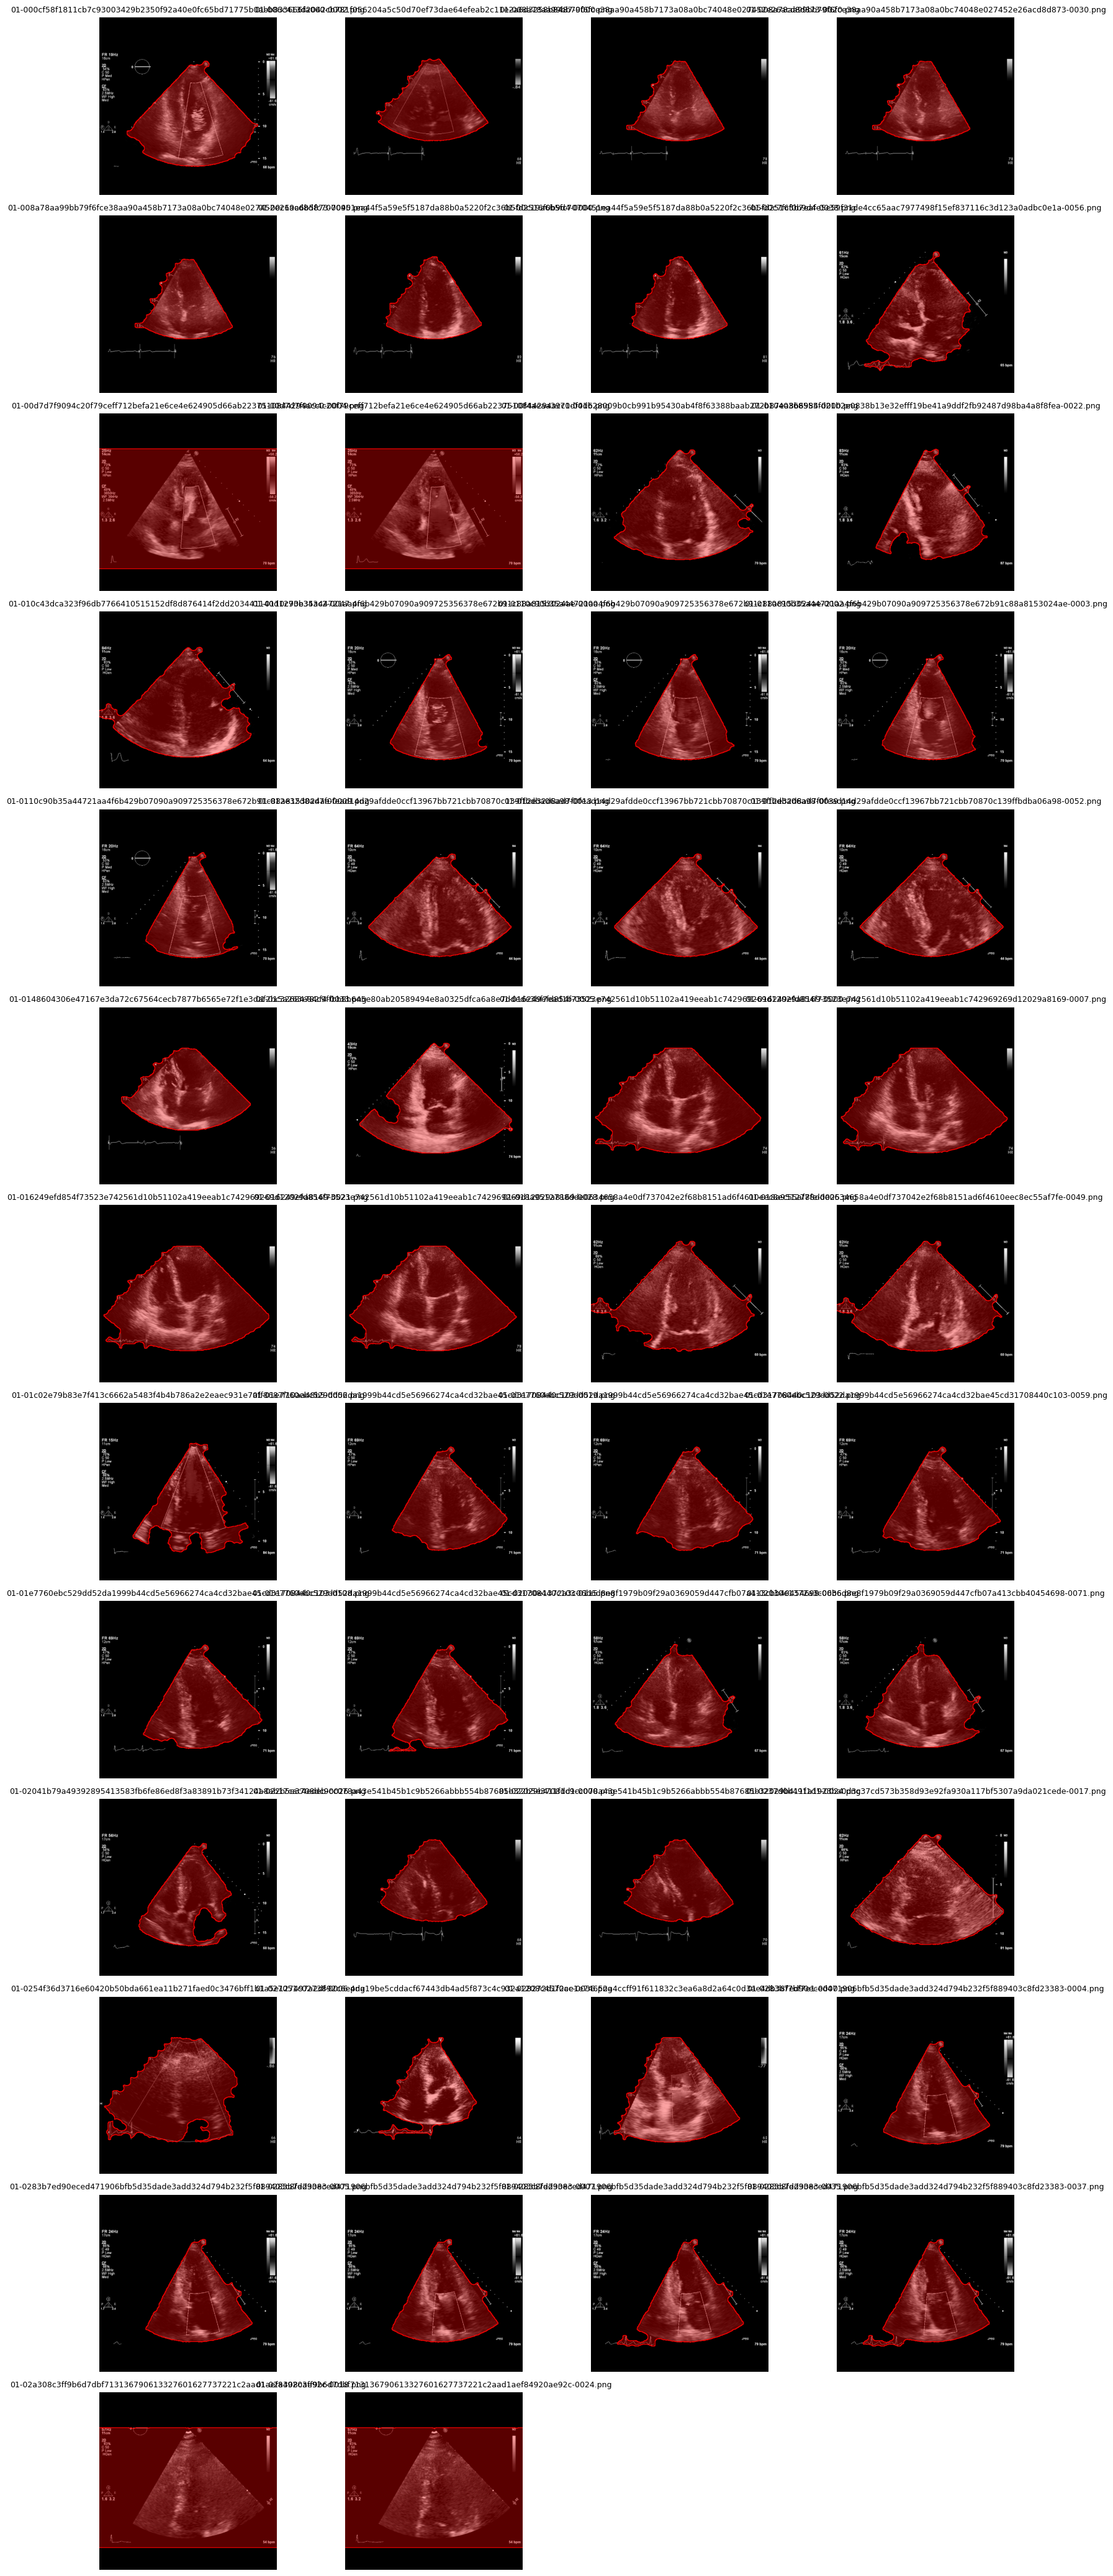

Done. Outputs in: ./fanmask_out_censored


In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =============================
# Small helpers (yours)
# =============================
def ensure_gray(img_any):
    """Return a single-channel uint8 grayscale image from gray/BGR/BGRA input."""
    if img_any is None:
        raise ValueError("Input image is None.")
    if img_any.ndim == 2:
        gray = img_any
    elif img_any.ndim == 3 and img_any.shape[2] == 3:
        gray = cv2.cvtColor(img_any, cv2.COLOR_BGR2GRAY)
    elif img_any.ndim == 3 and img_any.shape[2] == 4:
        gray = cv2.cvtColor(img_any, cv2.COLOR_BGRA2GRAY)
    else:
        raise ValueError(f"Unsupported image shape: {img_any.shape}")
    if gray.dtype != np.uint8:
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return gray

def to_rgb_for_display(img_any):
    """Return an RGB image for matplotlib, from gray/BGR/BGRA input."""
    if img_any.ndim == 2:
        return cv2.cvtColor(img_any, cv2.COLOR_GRAY2RGB)
    if img_any.ndim == 3 and img_any.shape[2] == 3:
        return cv2.cvtColor(img_any, cv2.COLOR_BGR2RGB)
    if img_any.ndim == 3 and img_any.shape[2] == 4:
        return cv2.cvtColor(img_any, cv2.COLOR_BGRA2RGB)
    raise ValueError(f"Unsupported image shape: {img_any.shape}")

def nonzero_to_one(img_gray, out_255=True):
    """Turn every non-zero pixel into 1 (or 255 if out_255=True)."""
    g = ensure_gray(img_gray)
    m01 = (g > 0).astype(np.uint8)  # {0,1}
    return (m01 * 255).astype(np.uint8) if out_255 else m01

def first_n_images(folder, n=9999, exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff",".gif")):
    files = []
    for name in sorted(os.listdir(folder)):
        if os.path.splitext(name.lower())[1] in exts:
            files.append(os.path.join(folder, name))
            if len(files) >= n:
                break
    return files

def make_overlay_rgb(img_gray, mask, color=(255, 0, 0), alpha=0.35):
    """Red overlay of mask on the (grayscale) image for visualization."""
    rgb = cv2.cvtColor(ensure_gray(img_gray), cv2.COLOR_GRAY2RGB)
    overlay = rgb.copy()
    m = (mask > 0)
    overlay[m] = (rgb[m] * (1 - alpha) + alpha * np.array(color)).astype(np.uint8)
    boundary = cv2.morphologyEx((mask > 0).astype(np.uint8) * 255,
                                cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8))
    overlay[boundary > 0] = color
    return overlay

# =============================
# Auto-censor side/top/bottom bars
# =============================
def _longest_true_span(bool_1d):
    """Return (start, end) of the longest contiguous True run. If none, (None,None)."""
    start = None
    best_start, best_len = None, 0
    for i, v in enumerate(bool_1d):
        if v and start is None:
            start = i
        elif not v and start is not None:
            L = i - start
            if L > best_len:
                best_len, best_start = L, start
            start = None
    if start is not None:
        L = len(bool_1d) - start
        if L > best_len:
            best_len, best_start = L, start
    if best_start is None:
        return None, None
    return best_start, best_start + best_len

def censor_side_bars(img_gray,
                     min_col_frac=0.02,
                     min_row_frac=0.02,
                     margin=6,
                     mode="mask"):
    """
    Suppress non-informative left/right (and top/bottom) bars.
    - Finds the largest contiguous content band by column and row projections of non-zero pixels.
    - mode='mask' keeps original size and zeros the outside; mode='crop' returns a cropped image.
    Returns: (sanitized_gray, content_mask, (r0,r1,c0,c1))
    """
    g = ensure_gray(img_gray)
    nz = (g > 0).astype(np.uint8)

    # Column-wise content (keep columns that have > min_row_frac of rows as nonzero)
    col_counts = nz.sum(axis=0)
    min_rows = max(1, int(min_row_frac * g.shape[0]))
    col_keep = col_counts > min_rows
    c0, c1 = _longest_true_span(col_keep)
    if c0 is None:  # fallback: keep all
        c0, c1 = 0, g.shape[1]

    # Row-wise content (remove thick black bands at top/bottom if any)
    row_counts = nz.sum(axis=1)
    min_cols = max(1, int(min_col_frac * g.shape[1]))
    row_keep = row_counts > min_cols
    r0, r1 = _longest_true_span(row_keep)
    if r0 is None:
        r0, r1 = 0, g.shape[0]

    # Expand a little
    c0 = max(0, c0 - margin); c1 = min(g.shape[1], c1 + margin)
    r0 = max(0, r0 - margin); r1 = min(g.shape[0], r1 + margin)

    content_mask = np.zeros_like(g, dtype=np.uint8)
    content_mask[r0:r1, c0:c1] = 255

    if mode == "crop":
        return g[r0:r1, c0:c1], content_mask, (r0, r1, c0, c1)
    else:
        out = g.copy()
        out[content_mask == 0] = 0
        return out, content_mask, (r0, r1, c0, c1)

# =============================
# Fan mask via morphology (yours)
# =============================
def fan_mask_morphology(img_any_or_bin, thr=15, open_ks=5, close_ks=21):
    """
    Returns a binary fan/scan mask (uint8 {0,255}) for an ultrasound image.
    - If input is already binary-like ({0,1,255}) we skip thresholding.
    """
    gray = ensure_gray(img_any_or_bin)
    vals = set(np.unique(gray).tolist())
    if vals <= {0, 1, 255}:
        bin0 = ((gray > 0).astype(np.uint8) * 255)
    else:
        _, bin0 = cv2.threshold(gray, int(thr), 255, cv2.THRESH_BINARY)

    k_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
    bin1    = cv2.morphologyEx(bin0, cv2.MORPH_OPEN,  k_open,  iterations=1)
    bin2    = cv2.morphologyEx(bin1, cv2.MORPH_CLOSE, k_close, iterations=1)

    contours, _ = cv2.findContours(bin2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros_like(bin2, dtype=np.uint8)
    largest = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(bin2, dtype=np.uint8)
    cv2.drawContours(mask, [largest], -1, 255, thickness=cv2.FILLED)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_close, iterations=1)
    return mask

# =============================
# Simple viewer
# =============================
def show_triplet(img_gray, censored_gray, mask, title=""):
    ov = make_overlay_rgb(img_gray, mask)
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].imshow(img_gray, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
    ax[1].imshow(censored_gray, cmap="gray"); ax[1].set_title("Censored L/R (and bands)"); ax[1].axis("off")
    ax[2].imshow(ov); ax[2].set_title("Fan Mask Overlay"); ax[2].axis("off")
    fig.suptitle(title)
    plt.tight_layout(); plt.show()

# =============================
# Batch example
# =============================
if __name__ == "__main__":
    # >>>> SET THESE <<<<
    FOLDER  = r"/workspace/data/unity-u4s/images/training"  # folder of images
    OUT_DIR = os.path.join("./", "fanmask_out_censored")
    N       = 50

    os.makedirs(OUT_DIR, exist_ok=True)
    files = first_n_images(FOLDER, n=N)
    if not files:
        raise SystemExit(f"No images found in: {FOLDER}")

    print(f"Processing {len(files)} images from: {FOLDER}")
    overlays_for_grid, names_for_titles = [], []

    for i, fp in enumerate(files, 1):
        img = cv2.imread(fp, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"[WARN] Could not read: {fp}")
            continue
        gray = ensure_gray(img)

        # A) Censor left/right (and top/bottom) bars
        censored_gray, content_mask, _ = censor_side_bars(
            gray, min_col_frac=0.02, min_row_frac=0.02, margin=6, mode="mask"
        )

        # B) Optional: reduce to {0,255} first (robust on very dark backgrounds)
        bin_nz = nonzero_to_one(censored_gray, out_255=True)

        # C) Morphology-based fan mask on the sanitized image
        mask = fan_mask_morphology(bin_nz, thr=15, open_ks=5, close_ks=21)

        # D) Save outputs
        base = os.path.splitext(os.path.basename(fp))[0]
        out_cens = os.path.join(OUT_DIR, f"{base}_censored.png")
        out_mask = os.path.join(OUT_DIR, f"{base}_mask.png")
        out_ovl  = os.path.join(OUT_DIR, f"{base}_overlay.png")

        cv2.imwrite(out_cens, censored_gray)
        cv2.imwrite(out_mask,  mask)
        ov_rgb = make_overlay_rgb(gray, mask)
        cv2.imwrite(out_ovl, cv2.cvtColor(ov_rgb, cv2.COLOR_RGB2BGR))

        overlays_for_grid.append(ov_rgb)
        names_for_titles.append(os.path.basename(fp))
        print(f"[{i:02d}/{len(files)}] Saved → {out_cens}, {out_mask}, {out_ovl}")

    # Quick gallery
    if overlays_for_grid:
        cols = 4
        rows = int(np.ceil(len(overlays_for_grid) / cols))
        plt.figure(figsize=(4*cols, 3.2*rows))
        for i, ov in enumerate(overlays_for_grid, 1):
            ax = plt.subplot(rows, cols, i)
            ax.imshow(ov)
            ax.set_title(names_for_titles[i-1], fontsize=9)
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    print(f"Done. Outputs in: {OUT_DIR}")
